In [ ]:
from google.colab import files
upload=files.upload()

Saving Fraud_Data.csv to Fraud_Data (1).csv
Saving IpAddress_to_Country.csv to IpAddress_to_Country.csv


# Questions:

For each user, determine her country based on the numeric IP address.
Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

Your boss is a bit worried about using a model she doesn't understand for something as important as fraud detection. How would you explain her how the model is making the predictions? Not from a mathematical perspective (she couldn't care less about that), but from a user perspective. What kinds of users are more likely to be classified as at risk? What are their characteristics?

Let's say you now have this model which can be used live to predict in real time if an activity is fraudulent or not. From a product perspective, how would you use it? That is, what kind of different user experiences would you build based on the model output?

# Answers:
below seperately

In [ ]:
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn import tree
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import graphviz
import seaborn as sn

%matplotlib inline

In [ ]:
fraud=pd.read_csv("Fraud_Data (1).csv")
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [ ]:
fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [ ]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [ ]:
ip_to_country=pd.read_csv("IpAddress_to_Country.csv")
ip_to_country.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [ ]:
ip_to_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   lower_bound_ip_address  138846 non-null  float64
 1   upper_bound_ip_address  138846 non-null  int64  
 2   country                 138846 non-null  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


Test1:Add country to fraud table

In [ ]:
country_arr=[]
for index1, row1 in fraud.iterrows():
  tmp=ip_to_country[(row1['ip_address']>=ip_to_country['lower_bound_ip_address']) & (row1['ip_address']<= ip_to_country['upper_bound_ip_address'])]
  if (len(tmp))>0:
    country_arr.append(tmp['country'].values[0])
  else:
    country_arr.append('NA')

In [ ]:
fraud['country']=country_arr
fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


Feature Engineering

user_count: number of user_id using the same device_id

day_slot_signup_purchase: time between signup day and purchase day [d]

In [ ]:
fraud_group=fraud.groupby('device_id').agg({'user_id':'count'}).reset_index()
fraud_group=fraud_group.rename({'user_id':'n_shared_device'},axis='columns')

In [ ]:
fraud=fraud.merge(fraud_group.set_index('device_id'),on='device_id')

In [ ]:
fraud_group2=fraud.groupby('ip_address').agg({'user_id':'count'}).reset_index()
fraud_group2=fraud_group2.rename({'user_id':'n_shared_ip'},axis='columns')

In [ ]:
fraud=fraud.merge(fraud_group2.set_index('ip_address'),on='ip_address')

In [ ]:
#fraud['slot_signup_purchase']=(pd.Timestamp(fraud['purchase_time'])-pd.Timestamp(fraud['signup_time'])).astype('timedelta64[d]')

fraud['purchase_time']=pd.to_datetime(fraud['purchase_time'])
fraud['signup_time']=pd.to_datetime(fraud['signup_time'])
fraud['day_slot_signup_purchase']=(fraud['purchase_time']-fraud['signup_time']).astype('timedelta64[D]')

In [ ]:
fraud_dt=fraud.drop(columns=['device_id','ip_address','signup_time','purchase_time'])

In [ ]:
fraud_d=pd.get_dummies(fraud_dt,columns=['source','browser','sex'])

In [ ]:
# How many users are from the same country
n_country_shared = fraud_d.country.value_counts()

# The less visit from a country, the more suspicious
fraud_d['n_country_shared'] = fraud_d.country.map(n_country_shared)
del fraud_d['country']

In [ ]:
fraud_d

,user_id,purchase_value,age,class,n_shared_device_x,n_shared_ip_x,day_slot_signup_purchase,n_shared_device_y,n_shared_ip_y,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,n_country_shared
0,22058,34,39,0,1,1,52.0,1,1,0,0,1,1,0,0,0,0,0,1,7306
1,333320,16,53,0,1,1,0.0,1,1,1,0,0,1,0,0,0,0,1,0,58049
2,1359,15,53,1,12,12,0.0,12,12,0,0,1,0,0,0,1,0,0,1,58049
3,48288,15,53,1,12,12,0.0,12,12,0,0,1,0,0,0,1,0,0,1,58049
4,128706,15,53,1,12,12,0.0,12,12,0,0,1,0,0,0,1,0,0,1,58049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151107,356404,41,26,0,1,1,92.0,1,1,0,0,1,1,0,0,0,0,0,1,58049
151108,151643,23,18,0,1,1,80.0,1,1,1,0,0,0,1,0,0,0,0,1,58049
151109,274471,35,32,0,1,1,10.0,1,1,0,0,1,0,0,0,0,1,0,1,1680
151110,368416,40,26,0,1,1,77.0,1,1,0,0,1,0,0,1,0,0,1,0,7306


Build decision tree model to predict

In [ ]:
x=pd.concat([fraud_d.iloc[:,:3],fraud_d.iloc[:,4:]],axis=1)
y=fraud_d.iloc[:,3]

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x,y,random_state=42,test_size=0.2)

In [ ]:
parameters = {
    'max_depth': [2,3,4,5]}


In [ ]:
clf=tree.DecisionTreeClassifier()
gs_clf=GridSearchCV(clf, parameters, n_jobs=1, cv=2)
gs_clf = gs_clf.fit(x_train, y_train)
gs_clf.best_params_

{'max_depth': 2}

In [ ]:
print(gs_clf)

GridSearchCV(cv=2, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=1, param_grid={'max_depth': [2, 3, 4, 5]},
             pre_dispatch='2*n_jobs', ref

[Text(167.4, 181.2, 'X[4] <= 1.5\ngini = 0.17\nsamples = 120889\nvalue = [109579, 11310]'),
 Text(83.7, 108.72, 'X[3] <= 1.5\ngini = 0.087\nsamples = 114184\nvalue = [108974, 5210]'),
 Text(41.85, 36.23999999999998, 'gini = 0.059\nsamples = 105406\nvalue = [102184, 3222]'),
 Text(125.55000000000001, 36.23999999999998, 'gini = 0.35\nsamples = 8778\nvalue = [6790, 1988]'),
 Text(251.10000000000002, 108.72, 'X[5] <= 0.5\ngini = 0.164\nsamples = 6705\nvalue = [605, 6100]'),
 Text(209.25, 36.23999999999998, 'gini = 0.002\nsamples = 6082\nvalue = [7, 6075]'),
 Text(292.95, 36.23999999999998, 'gini = 0.077\nsamples = 623\nvalue = [598, 25]')]

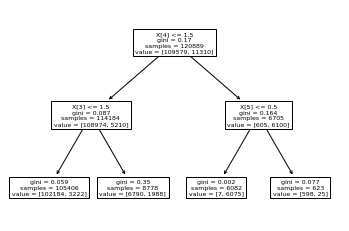

In [ ]:
tree.plot_tree(gs_clf.best_estimator_)

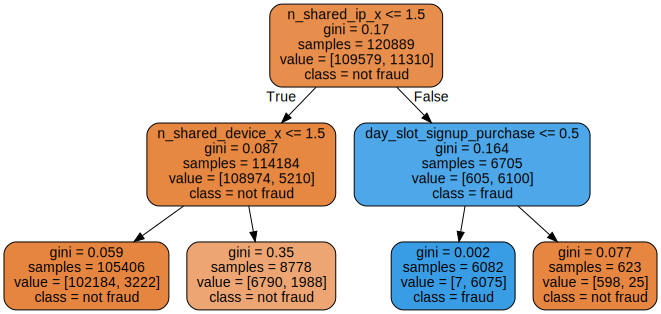

In [ ]:
y_train_name=y_train.map({0:'not fraud',1:'fraud'})
y_train.unique()
y_train_name.unique()
dot_data = tree.export_graphviz(gs_clf.best_estimator_, out_file=None, 
                       feature_names=list(x_train),
                       class_names=y_train_name.unique(),
                      filled=True, rounded=True)  
graph = graphviz.Source(dot_data)  
graph 

Test3: From decision tree model, we can see that if several user_ids share the same ip_address, it should be a signal of fraud. Also, if the user purchasing just after signing up, it's possible to suspect he is going to fraud. In addition, several users sharing the same device is also a signal to fraudulent activities.

In [ ]:
pred=gs_clf.predict(x_test)
print('accuracy score:',metrics.accuracy_score(y_test,pred))

accuracy score: 0.9565231777123383


In [ ]:
print(metrics.classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     27382
           1       1.00      0.54      0.70      2841

    accuracy                           0.96     30223
   macro avg       0.98      0.77      0.84     30223
weighted avg       0.96      0.96      0.95     30223



roc_auc_score for DecisionTree:  0.8464849563058084


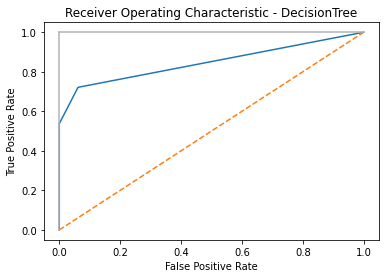

In [ ]:
# Get predicted probabilities
y_score1 = gs_clf.predict_proba(x_test)[:,1]

# Plot Receiving Operating Characteristic Curve
# Create true and false positive rates
false_positive_rate, true_positive_rate, threshold = metrics.roc_curve(y_test, y_score1)
print('roc_auc_score for DecisionTree: ', metrics.roc_auc_score(y_test, y_score1))

# Plot ROC curves
plt.title('Receiver Operating Characteristic - DecisionTree')
plt.plot(false_positive_rate, true_positive_rate)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

From this ROC curve plot, we can see that, if the cost of FP is very high, then we may want to choose a cut-off which TPR will be around 0.5 and FPR will be almost 0. While if FN costs a lot, we may want to increase the cut-off and safeguard a higher TPR. However, in this case, the FPR will increase with TPR after TPR going up to 0.6.

Build Logistic Regression for setting appropriate alert cutoffs

In [ ]:
label_encoder = LabelEncoder()

In [ ]:
fraud_dt['sex']=label_encoder.fit_transform(fraud_dt['sex'])
fraud_dt['country']=label_encoder.fit_transform(fraud_dt['country'])
fraud_dt['source']=label_encoder.fit_transform(fraud_dt['source'])
fraud_dt['browser']=label_encoder.fit_transform(fraud_dt['browser'])
fraud_dt.head()

,user_id,purchase_value,source,browser,sex,age,class,country,n_shared_device_x,n_shared_ip_x,day_slot_signup_purchase,n_shared_device_y,n_shared_ip_y
0,22058,34,2,0,1,39,0,84,1,1,52.0,1,1
1,333320,16,0,0,0,53,0,172,1,1,0.0,1,1
2,1359,15,2,3,1,53,1,172,12,12,0.0,12,12
3,48288,15,2,3,1,53,1,172,12,12,0.0,12,12
4,128706,15,2,3,1,53,1,172,12,12,0.0,12,12


In [ ]:
x_lr=pd.concat([fraud_dt.iloc[:,:6],fraud_dt.iloc[:,7:]],axis=1)
y_lr=fraud_dt.iloc[:,6]

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(x_lr,y_lr,random_state=42,test_size=0.2)

In [ ]:
lr=LogisticRegression()
lr = lr.fit(x_train, y_train)

In [ ]:
parameters2={
    'tol':[50,20,10,1,0.1],
    'C':[0.5,1.0,2.0],
    'solver':['lbfgs']
}

In [ ]:

gs_lr=GridSearchCV(lr, parameters2, n_jobs=1, cv=2)
gs_lr = gs_lr.fit(x_train, y_train)
gs_lr.best_params_

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


{'C': 1.0, 'solver': 'lbfgs', 'tol': 50}

In [ ]:
pred = gs_lr.predict(x_test)

In [ ]:
score = gs_lr.score(x_test, y_test)
print(score)

0.9059987426794164


In [ ]:
cm = metrics.confusion_matrix(y_test, pred)
print(cm)

[[27382     0]
 [ 2841     0]]


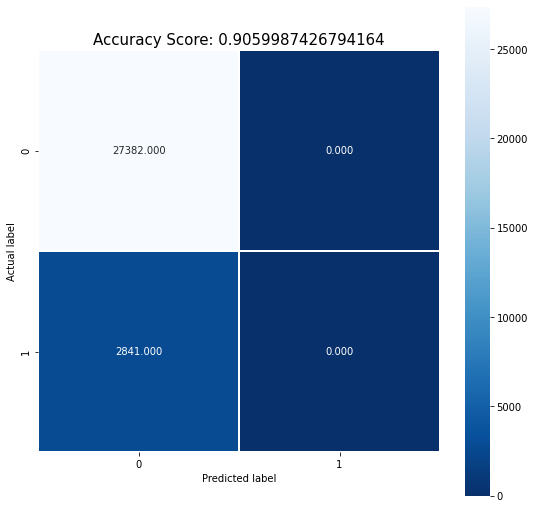

In [ ]:
plt.figure(figsize=(9,9))
sn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

In [ ]:
de=gs_lr.decision_function(x_train)
df = pd.DataFrame(data=de)
df.sort_values(by=[0])

,0
18482,-5.765827
119256,-5.634470
64792,-5.614924
65756,-5.603762
81085,-5.596111
...,...
21315,-0.093958
1387,-0.086619
103503,-0.078395
517,-0.061483


**test4: What kind of diﬀerent user experiences would you build based on the model output?**

Since my model can predict the probability a purchase is fraud, so I need to set two probability cutoffs as 'alert value', alert1 and alert2, and alert1 < alert2 .

For a incoming purchase, my model will return the probability 'p' that the purchase is fraud,

If p < alert1, then I assume the purchase is normal, proceed without any problem
If alert1 <= p < alert2, then I assume the purchase is suspicious, I will ask the customer for additional authroization. for example, send email or SMS to the customer, let him/her authorize the purchase.
If p>= alert2, then the purchase is highly suspicious, I not only ask the customer for additional authorization via email or SMS, but also put the purchase on hold and send the purchase information to some human expert for further investigation.